# Policy Gradient

After playing with DQN which is an Off-Policy Algorithm which tries to estimate the possible futur reward of taking an action at a given state. It exist a second kind of RL algorithm which is a Policy algorithm. Here, we only try to find the best action based on a given state. At the end, they seems similar because we can say that taking the highest Q on a DQN is similar to Policy Gradient but in term of training it's not.

For DQN, we take several episodes, estimates the Q-value based on Bellman's equation and train a regressor to minimize the loss between the model's prediction and the estimated Q-value. Here, we don't need experience replay but we will use one or more "Trajectory" (A trajectory is a chain of states, actions, and rewards collected while moving in the environement). As a result, we will use only one-or more games to store (State / Action / Reward pairs). Based on this, the model will evolve based on the result of the policy. If the trajectory leads to a bad reward, it will change to not do the same the time after.

As far as I know, we can use this algorithm for the same kind of problem as DQN where the action is a binary "vector". To train it, it is also required to get often rewards else we may never see a reward an not be able to learn. For this, we will do it on CartPole

<b>Information : </b> A very good presentation of Policy Gradient is available <a href="https://medium.freecodecamp.org/an-introduction-to-policy-gradients-with-cartpole-and-doom-495b5ef2207f">here<a/>

# Exploration of the environment

We already saw this environement in the past (for Q-learning and DQN). As a result I'll only re-explore for the last time the distribution of state variables

In [1]:
import numpy as np
import tensorflow as tf
import gym
import imageio

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gym.make("CartPole-v0")
state = np.zeros((10000, 4))
done= True
for i in range(10000):
    if done:
        obs = env.reset()
    else:
        obs = next_obs
    state[i] = obs
    next_obs, reward, done, info = env.step(env.action_space.sample())

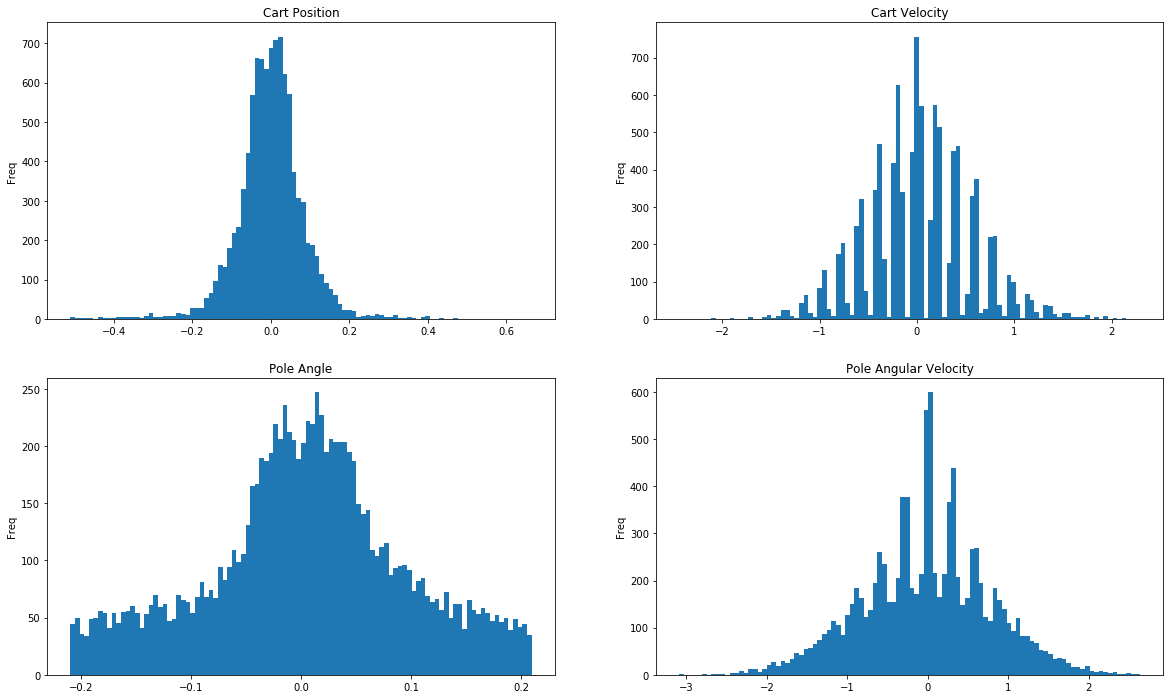

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(20,12))
titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]
for i, title, ax in zip(range(4), titles, axes.flatten()):
    ax.hist(state[:, i], bins=100)
    ax.set_title(title)
    ax.set_ylabel("Freq")
plt.show()

In [4]:
print("Lower Bound : ", np.min(state, axis=0))
print("Upper Bound : ", np.max(state, axis=0))

Lower Bound :  [-0.51068898 -2.44315821 -0.20940359 -3.08982008]
Upper Bound :  [0.66381492 2.29543826 0.20929881 2.6389055 ]


# Reward improvement tests

We will train multiple networks in this notebooks and based on the state, we will create a custom reward to see if it has an impact of the learning speed and quality. The reward will still be between 0 and 1 but it will decrease based on pole angle and position. The default env provides a reward of 1 if angle < 12 deg and abs(X position) < 2.4. That means that the policy doesn't try to maintain the pole as straigt as possible and in the middle.

Let's now plot the reward with different power values

In [5]:
def get_reward(x, y, power):
    dx = np.maximum(0, 2.4-np.abs(x))
    dy = np.maximum(0, 0.21-np.abs(y))
    pos_part = np.power(dx, power)/np.power(2.4, power)
    ang_part = np.power(dy, power)/np.power(0.21, power)
    return  pos_part * ang_part

def enhance_reward(obs, power = 1):
    x, vx, theta, theta_dot = obs
    reward = get_reward(x, theta, power)
    return reward

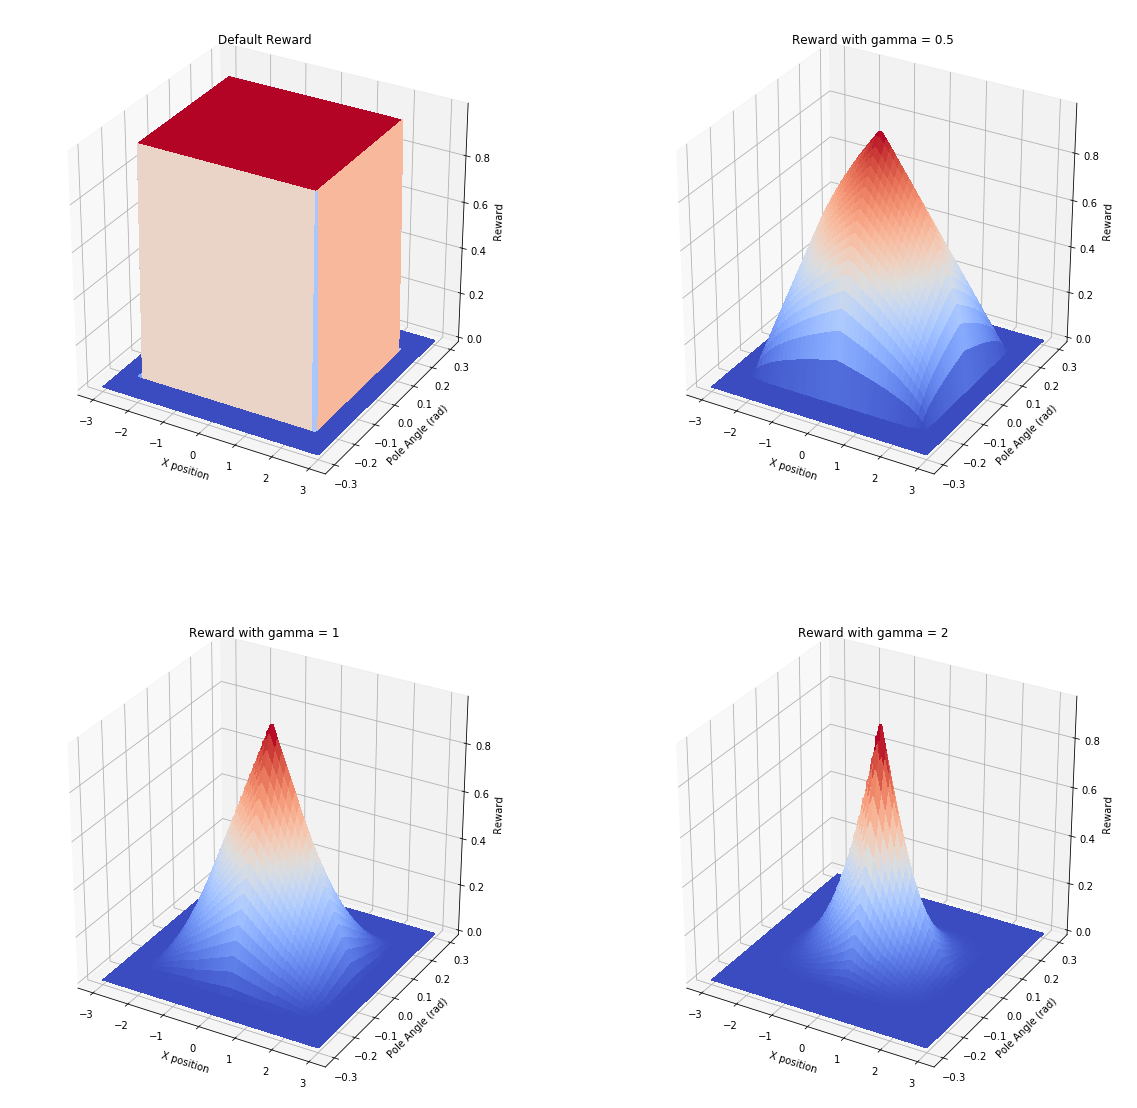

In [28]:
pos = np.linspace(-3, 3, 100)
ang = np.linspace(-0.3, 0.3, 100)
X, Y = np.meshgrid(pos, ang)

fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(2, 2, 1, projection='3d')
Z = get_reward(X, Y, 0.000001)
p = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=False)
ax.set_xlabel("X position")
ax.set_ylabel("Pole Angle (rad)")
ax.set_zlabel("Reward")
ax.set_title("Default Reward")

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
Z = get_reward(X, Y, 0.5)
p = ax2.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=False)
ax2.set_xlabel("X position")
ax2.set_ylabel("Pole Angle (rad)")
ax2.set_zlabel("Reward")
ax2.set_title("Reward with gamma = 0.5")

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
Z = get_reward(X, Y, 1)
p3 = ax3.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=False)
ax3.set_xlabel("X position")
ax3.set_ylabel("Pole Angle (rad)")
ax3.set_zlabel("Reward")
ax3.set_title("Reward with gamma = 1")

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
Z = get_reward(X, Y, 2)
p4 = ax4.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=False)
ax4.set_xlabel("X position")
ax4.set_ylabel("Pole Angle (rad)")
ax4.set_zlabel("Reward")
ax4.set_title("Reward with gamma = 2")

plt.show()

We can see that if the model wants a reward of 1, it has to be perfectly vertical in the middle. The value decrease based on the power selected.

<B>Note :</B> To evaluate the learning, I'll still save the reward provided by the environment to have the same baseline.

# Model

First we will need 2 functions. For each Trajectory, we will have a tuple (state, action, reward). Based on that, we will compute a discounted reward 

\begin{equation*}
DiscountedReward(t) = \sum_{T = t}^{+\infty} \gamma Reward(T)
\end{equation*}

Then, the idea is to normalize this batch of reward (by using Standard Scaling)

In [7]:
def render_frames_as_gif(frames, filename):
    imageio.mimsave(filename, frames, duration = 1/35.)

def discount_rewards(rewards, discount_rate):
    n = len(rewards)
    discounted_rewards = np.zeros(n)
    discounted_rewards[-1] = rewards[-1]
    for step in reversed(range(n-1)):
        discounted_rewards[step] = rewards[step] + discounted_rewards[step+1] * discount_rate
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = []
    for rewards in all_rewards:
        discounted = discount_rewards(rewards, discount_rate)
        all_discounted_rewards.append(discounted)
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

Now, let's create our Model for Policy Gradient. This model can be simple in this case. We can only have one output for the action to go left. Based on this probability we can choose to go right. This is the "MDL 1". The seocnd model is using a softmax to get probabilities for each actions. We will use this one which is more aesy to extrapolate to other envs.

In [8]:
class Model:
    def __init__(self):
        self.n_inputs = 4
        self.n_outputs = 1
        self.learning_rate = 0.01
        self.initializer = tf.contrib.layers.variance_scaling_initializer()
        
        # Model
        self.X = tf.placeholder(tf.float32, shape=[None, self.n_inputs])
        
        ## MDL 1
#         self.hidden1 = tf.layers.dense(self.X, 4, 
#                             activation=tf.nn.elu, 
#                             kernel_initializer=self.initializer,
#                             name = "H")
#         self.logits = tf.layers.dense(self.hidden1, self.n_outputs,
#                             kernel_initializer=self.initializer, 
#                             name = "O")
#         self.output = tf.nn.sigmoid(self.logits)
        
#         self.probs_action = tf.concat(axis=1, values=[self.output, 1 - self.output])
#         self.action = tf.multinomial(tf.log(self.probs_action), num_samples=1)
#         self.y = 1. - tf.to_float(self.action)
#         self.loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.y, logits=self.logits)


        ## MDL 2
        self.hidden1 = tf.layers.dense(self.X, 10, 
                            activation=tf.nn.elu, 
                            kernel_initializer=self.initializer,
                            name = "H")
        self.hidden2 = tf.layers.dense(self.hidden1, 10, 
                            activation=tf.nn.elu, 
                            kernel_initializer=self.initializer,
                            name = "H2")
        self.logits = tf.layers.dense(self.hidden2, 2,
                            kernel_initializer=self.initializer, 
                            name = "O")
        self.output = tf.nn.softmax(self.logits)

        self.action = tf.multinomial(tf.log(self.output), num_samples=1)
        self.y = tf.one_hot(indices=self.action, depth=2)
        self.loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = self.y, logits = self.logits)
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        
        self.grads_and_tensors = self.optimizer.compute_gradients(self.loss)
        self.gradients = [grad for grad, variable in self.grads_and_tensors]
        
        self.gradient_placeholders = []
        self.grads_and_vars_feed = []
        for grad, tensor in self.grads_and_tensors:
            self.gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
            self.gradient_placeholders.append(self.gradient_placeholder)
            self.grads_and_vars_feed.append((self.gradient_placeholder, tensor))
        self.training_op = self.optimizer.apply_gradients(self.grads_and_vars_feed)
        
        self.init = tf.global_variables_initializer()

# Cartpole

Now we can create the Agent. As we will try multiple power for the custom reward, we have to ensure that our model at initialisation stage will be the same. This can be done by fixing a seed in Tensorflow and running only in CPU. Indeed, with GPU, Tensorflow may initialize models with small differences (<a href="https://www.youtube.com/watch?v=Ys8ofBeR2kA">Video from Aurélien Géron</a>)

In [9]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

mdl = Model()

We can evaluate a tensor with multiple init just to see the reproductibility

In [10]:
for _ in range(4):
    with tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})) as sess:
        mdl.init.run()
        with tf.variable_scope("H", reuse=True):
            w = tf.get_variable("kernel")
            print(w.eval(session=sess))

[[-0.45510635  0.81582963  1.2056338   1.0994971  -0.56358564  0.2888492
  -0.69138104 -0.06527361  0.04471029 -0.29640263]
 [ 0.06188473 -0.5163936  -0.58866525  0.06967854  0.5815372  -1.2069439
  -0.47884342  1.1362388   0.24403518 -0.727044  ]
 [ 0.18851842  0.39979592  0.08313183  0.44505516 -1.2556353  -0.48907927
  -0.9885021   0.06804872  0.44944328  0.90450716]
 [ 1.3076719   1.1061292  -1.1870697  -0.10433766 -0.6565466   0.89954984
  -0.20217371 -1.1621997   0.02519698  0.2979564 ]]
[[-0.45510635  0.81582963  1.2056338   1.0994971  -0.56358564  0.2888492
  -0.69138104 -0.06527361  0.04471029 -0.29640263]
 [ 0.06188473 -0.5163936  -0.58866525  0.06967854  0.5815372  -1.2069439
  -0.47884342  1.1362388   0.24403518 -0.727044  ]
 [ 0.18851842  0.39979592  0.08313183  0.44505516 -1.2556353  -0.48907927
  -0.9885021   0.06804872  0.44944328  0.90450716]
 [ 1.3076719   1.1061292  -1.1870697  -0.10433766 -0.6565466   0.89954984
  -0.20217371 -1.1621997   0.02519698  0.2979564 ]]
[[

And we can see that there is no differences so we will be able to compare all models with the same base

In [11]:
env = gym.make("CartPole-v0")
n_games_per_update = 8
n_max_steps = 200
n_iterations = 200
discount_rate = 0.95
config = tf.ConfigProto(device_count = {'GPU': 0})

The Agent should run N times K games. After every K games, it computes the discounted normalized reward and multiply the attached set of gradient by this value. This will have the benefit to increase gradient for an action giving a huge reward and invert actions leading to a bad reward (as the reward will be negative). This will be done N times and then we will be able to run an agent on a game to evaluate it

In [12]:
results = {}
for param in [0.00001, 0.5, 1.0, 2.0]:
    print("alpha = {}".format(param))
    tf.set_random_seed(42)
    with tf.Session(config=config) as sess:
        mdl.init.run()
        scores = []
        for iteration in range(n_iterations):
            all_rewards = []
            all_gradients = []
            for game in range(n_games_per_update):
                game_score = 0
                current_rewards = []
                current_gradients = []
                obs = env.reset()
                for step in range(n_max_steps):
                    action, grads, output, loss = sess.run(
                        [mdl.action, mdl.gradients, mdl.output, mdl.loss], 
                        feed_dict={mdl.X: np.expand_dims(obs, 0)})
                    obs, reward, done, info = env.step(action[0][0])
                    game_score += reward
                    reward = enhance_reward(obs, power=param)
                    current_rewards.append(reward)
                    current_gradients.append(grads)
                    if done:
                        break
                scores.append(game_score)
                all_rewards.append(current_rewards)
                all_gradients.append(current_gradients)
            
            # Learning Phase
            all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
            feed_dict = {}
            for index_placeholder, gradient_placeholder in enumerate(mdl.gradient_placeholders):
                temp_grad = []
                for game_index, rewards in enumerate(all_rewards):
                    for step_index, reward in enumerate(rewards):
                        temp_grad.append(reward * all_gradients[game_index][step_index][index_placeholder])
                feed_dict[gradient_placeholder] = np.mean(temp_grad, axis=0)

            sess.run(mdl.training_op, feed_dict=feed_dict)
            print("Iter  : {} - Reward : {:.3f}".format(iteration, sum(scores[-n_games_per_update:]) / n_games_per_update), end="\r")
        print("")
        
        frames = []
        obs = env.reset()
        for step in range(n_max_steps):
            frames.append(env.render(mode = 'rgb_array'))
            action = sess.run([mdl.action], feed_dict={mdl.X: np.expand_dims(obs, 0)})
            obs, reward, done, info = env.step(action[0][0][0])
            if done:
                break
#         render_frames_as_gif(frames, "result_alpha_{}.gif".format(param))
        
    results[param] = scores

env.close()

alpha = 1e-05
Iter  : 199 - Reward : 200.000
alpha = 0.5
Iter  : 199 - Reward : 200.000
alpha = 1.0
Iter  : 199 - Reward : 194.875
alpha = 2.0
Iter  : 199 - Reward : 200.000


# Results

Now we have the score for every parameters of every games. We can plot the evolution to see if the custom rewards impacted a lot the speed of learning.

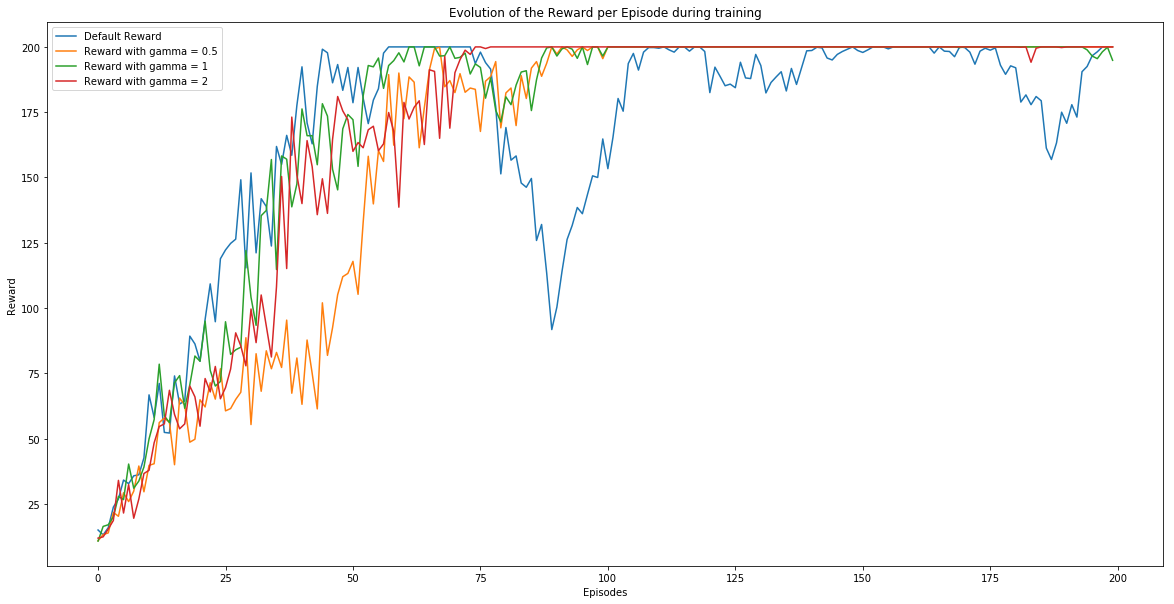

In [27]:
plt.figure(figsize=(20,10))
labels = ["Default Reward", "Reward with gamma = 0.5", "Reward with gamma = 1", "Reward with gamma = 2"]
pows = [0.00001, 0.5, 1.0, 2.0]
for param, label in zip(pows, labels):
    v = np.array(results[param]).reshape(n_iterations, n_games_per_update).mean(axis=1)
    plt.plot(v, label=label)
plt.legend()
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.title("Evolution of the Reward per Episode during training")
plt.show()

We can see that the training is slightly faster with the Standard reward because the discounted reward is bigger due to the fact that the reward is either 0 or 1. For other ones, it's an float between 0 and 1. The reward with a power of 0.5 or 2 are very similar in term of learning. The worst case is with a reward using no power. It's difficult to understand why but I tried other trials with different Learning rate, seed, iterations and it's everytime the same result. The most stable case seems to be with Power = 2. This can be understood because the model has reward only when the cart il close to be at perfect position and decrease faster than the other reward function. As a result, the policy tend to remain in this small part of states and get lot of rewards.

## test

We can review now policies for every parameters

### Standard Reward

<img src="result_alpha_1e-05.gif"/>

We can see a fail on this trial where the pole takes too much angle. The policy is not very stable because the agent doesn't really know when he is limit. For it, being a X=0 with an angle=0 deg is the same a X=2.399 and angle=11.99 deg. As a result, in some case, it may fail

### Power = 0.5

<img src="result_alpha_0.5.gif"/>

This model is working fine. It has slight move along X because the reward decrease not fast enough so it didn't try to compensate directly

### Power = 1.0

<img src="result_alpha_1.0.gif"/>

This model completely failed. As we can see on the previous learning result, the models started to have a decreasing reward and the policy may have been corrected too much in previous games (this is due to the credit assignment problem) A pair of good actions may have been wrongly evaluated in last games and "destroyed the policy complely). Few more epoch may solve this issue.

### Power = 2.0

<img src="result_alpha_2.0.gif"/>

To finish, this model is close to perfection. It nearly never move except at the beginning when it wants to compensate the stating angle

# Conclusion

We discover Policy Gradient model this week. It's the first step into Policy models. In futur weeks we will see another model which replaced this one called Proximal Policy Optimization (PPO) and Actor Critic (A2C).